In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import copy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# getting data 
numb_batch = 64
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

100%|██████████| 9912422/9912422 [00:00<00:00, 101421984.46it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50620849.91it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23918502.19it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8918786.88it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [7]:
#model
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [8]:
#validate model
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [9]:
#training
def train(numb_epoch=3, lr=1e-3, device="gpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  95.54000091552734
Epoch: 1 Accuracy : 95.54000091552734 %
Saving Best Model with Accuracy:  96.51000213623047
Epoch: 2 Accuracy : 96.51000213623047 %
Saving Best Model with Accuracy:  97.56999969482422
Epoch: 3 Accuracy : 97.56999969482422 %
Saving Best Model with Accuracy:  98.0
Epoch: 4 Accuracy : 98.0 %
Saving Best Model with Accuracy:  98.0999984741211
Epoch: 5 Accuracy : 98.0999984741211 %
Saving Best Model with Accuracy:  98.38999938964844
Epoch: 6 Accuracy : 98.38999938964844 %
Saving Best Model with Accuracy:  98.45999908447266
Epoch: 7 Accuracy : 98.45999908447266 %
Saving Best Model with Accuracy:  98.4800033569336
Epoch: 8 Accuracy : 98.4800033569336 %
Saving Best Model with Accuracy:  98.58999633789062
Epoch: 9 Accuracy : 98.58999633789062 %
Saving Best Model with Accuracy:  98.61000061035156
Epoch: 10 Accuracy : 98.61000061035156 %
Epoch: 11 Accuracy : 98.5199966430664 %
Saving Best Model with Accuracy:  98.73999786376953
Epoch: 12 Accurac

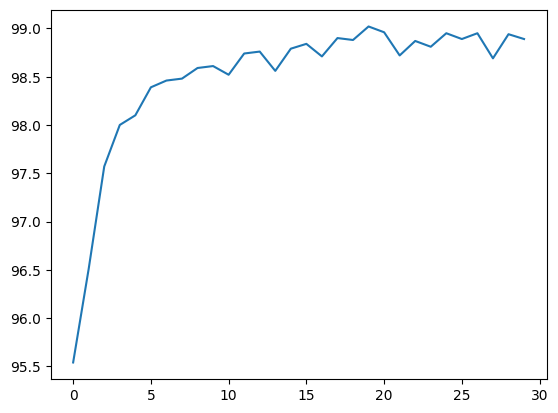

In [12]:
 device = torch.device("cuda:0")
lenet = train(30, device=device)

In [13]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [14]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [25]:
import requests
from PIL import Image
from io import BytesIO
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [44]:
#number 8
path = " https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
#number 4
#path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400032/79321927-handwritten-sketch-black-number-4-on-white-background.jpg"
#number3
#path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400051/79321944-handwritten-sketch-black-number-3-on-white-background.jpg"
# numer 5
#path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400061/79321951-handwritten-sketch-black-number-5-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
    x = (255 - np.expand_dims(np.array(img), -1))/255.

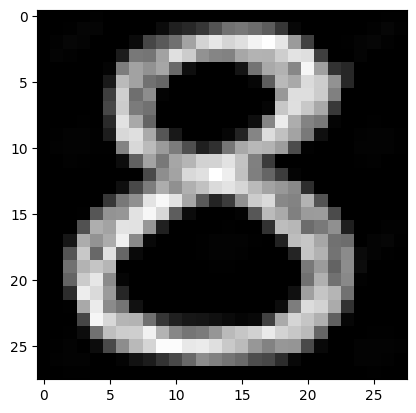

In [45]:
plt.imshow(x.squeeze(-1), cmap="gray")


In [46]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 99.99978542327881 %
